# Pet Finder - Adopción de Mascotas

PetFinder.es una plataforma de adopción de Mascotas de Malasia, con una base de datos de más de 150.000 animales. 

Las tasas de adopción de animales están fuertemente correlacionadas con los metadatos asociados con sus perfiles en línea, como el texto descriptivo y las características de las fotografías. Como ejemplo, PetFinder está experimentando actualmente con una herramienta de inteligencia artificial simple llamada Cuteness Meter, que clasifica qué tan linda es una mascota en función de las cualidades presentes en sus fotos.

En esta competencia, desarrollará algoritmos para predecir la adoptabilidad de las mascotas, específicamente, ¿qué tan rápido se adopta una mascota?

Web Organización: https://www.petfinder.my/

Datos: https://www.kaggle.com/c/petfinder-adoption-prediction



## Script Inicial - Análisis Exploratorio

En este trabajo se busca predecir la velocidad a la que se adopta una mascota, según la lista de la mascota en PetFinder. 

A veces, un perfil representa a un grupo de mascotas. En este caso, la velocidad de adopción está determinada por la velocidad a la que se adoptan todas las mascotas. 

Los datos incluyen datos de **Texto Libre**, **Datos Tabulares** e **Emágenes**, lo que lo hace un dataset sumamente rico para explorar

### Ejemplos de Scripts de EDA (Exploratory Data Analysis)

* En R: https://www.kaggle.com/jaseziv83/an-extensive-eda-of-petfinder-my-data
* En Python: https://www.kaggle.com/artgor/exploration-of-data-step-by-step

File descriptions:

* train.csv - Tabular/text data for the training set
* test.csv - Tabular/text data for the test set
* sample_submission.csv - A sample submission file in the correct format
* breed_labels.csv - Contains Type, and BreedName for each BreedID. Type 1 is dog, 2 is cat.
* color_labels.csv - Contains ColorName for each ColorID
* state_labels.csv - Contains StateName for each StateID

In [2]:
# Importación de Librerías
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from wordcloud import WordCloud

%matplotlib inline
pd.set_option('display.max_columns', 30)
plt.rcParams['figure.figsize'] = [12.0, 8.0]

In [74]:
# Datos Tabulares
train = pd.read_csv('C:/Users/FBorbiconi/OneDrive - Universidad Austral/Documentos/MCD/Laboratorio de implementación 2/Dataset/train/train.csv')

In [5]:
train.shape

(14993, 24)

In [6]:
train.head() 

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


### Data Fields

* PetID - Unique hash ID of pet profile
* AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to StateLabels dictionary)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* PhotoAmt - Total uploaded photos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

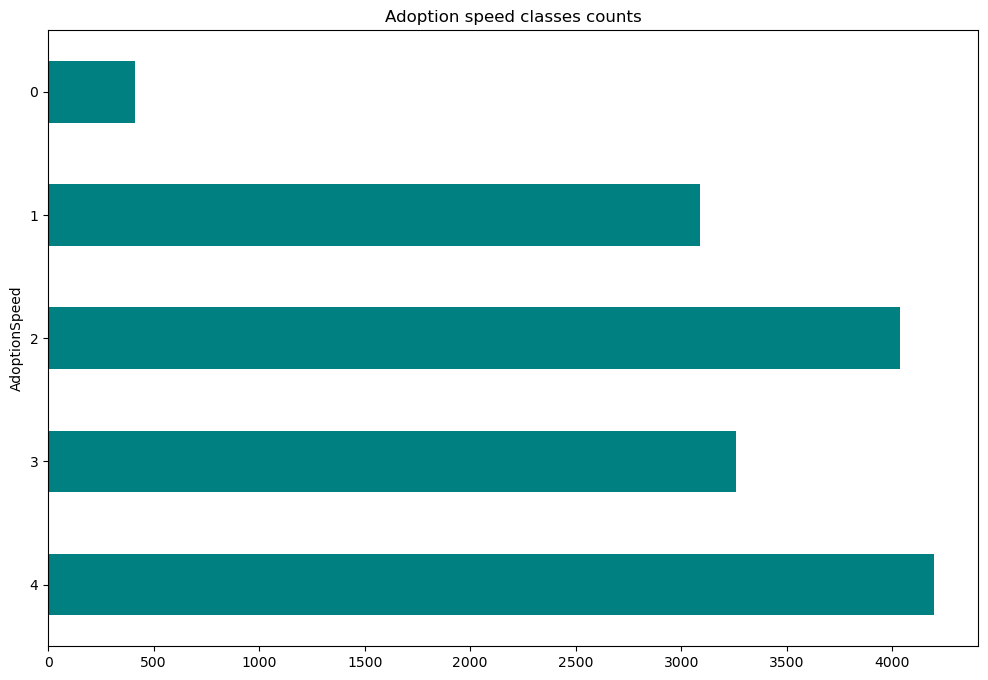

In [7]:
train['AdoptionSpeed'].value_counts().sort_index(ascending = False).plot(kind='barh', color='teal');
plt.title('Adoption speed classes counts');

### Target: AdoptionSpeed

The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way:

* 0 - Pet was adopted on the same day as it was listed.
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [75]:
# Mapeamos el Tipo de Mascota
train['Type'] = train['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')

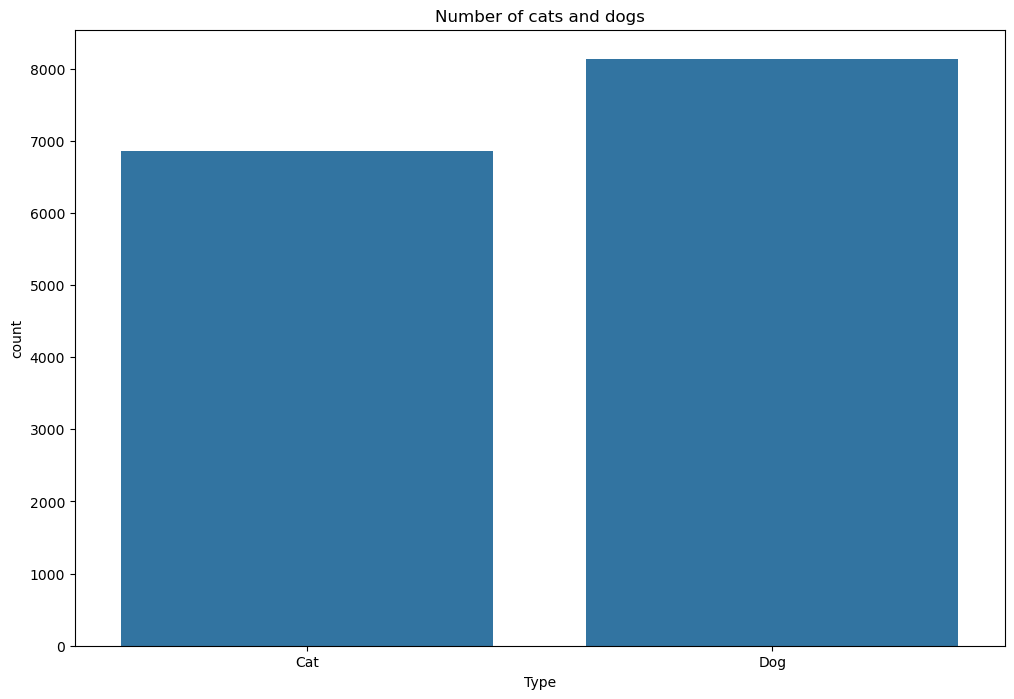

In [9]:
sns.countplot(x='Type', data=train);
plt.title('Number of cats and dogs');

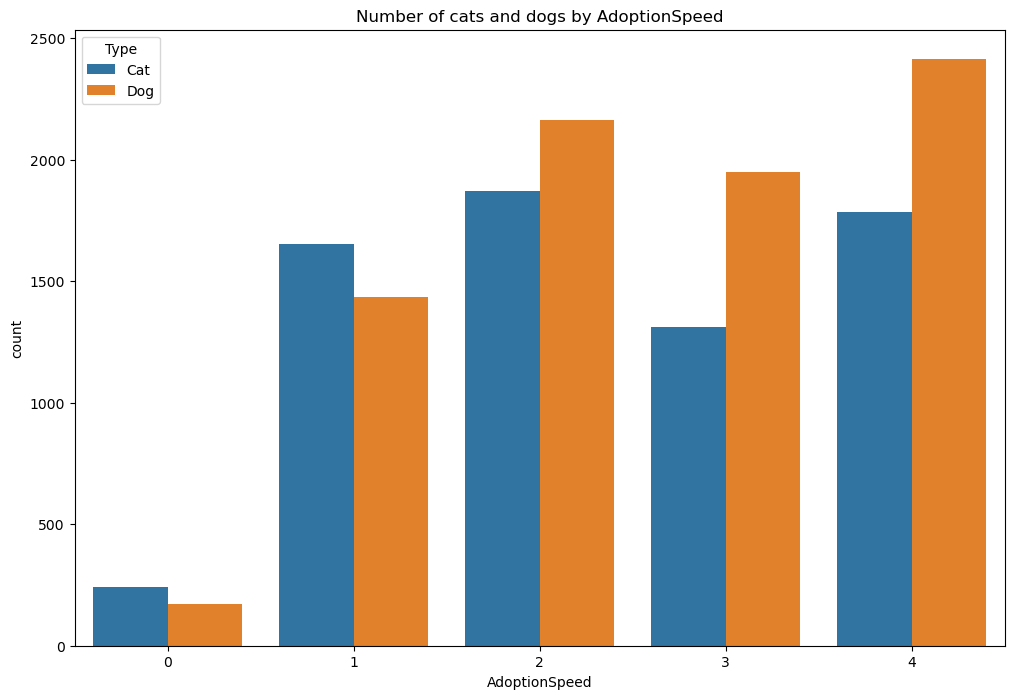

In [10]:
sns.countplot(x='AdoptionSpeed', data=train, hue='Type');
plt.title('Number of cats and dogs by AdoptionSpeed');

In [9]:
train.Name.value_counts()

Name
Baby                      66
Lucky                     64
No Name                   54
Brownie                   54
Mimi                      52
                          ..
Maroo                      1
4 PUPPIES FOR ADOPTION     1
Trish                      1
Lab Mix Puppy 2            1
Fili                       1
Name: count, Length: 9059, dtype: int64

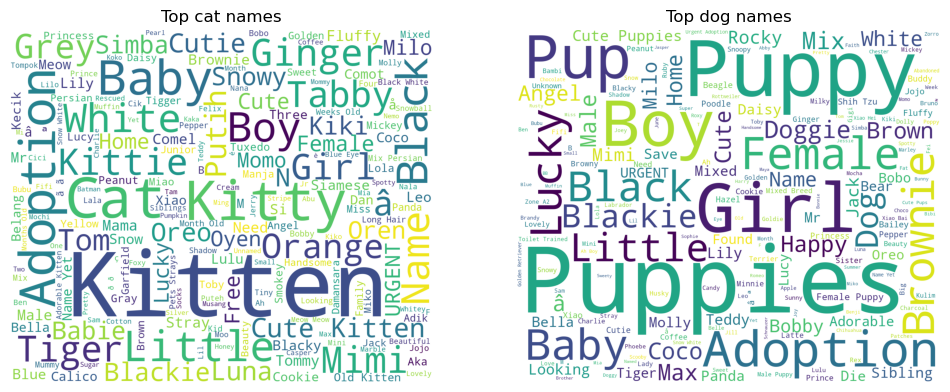

In [ ]:
plt.subplot(1, 2, 1)
text_cat = ' '.join(train.loc[train['Type'] == 'Cat', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_cat)
plt.imshow(wordcloud)
plt.title('Top cat names')
plt.axis("off")

plt.subplot(1, 2, 2)
text_dog = ' '.join(train.loc[train['Type'] == 'Dog', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_dog)
plt.imshow(wordcloud)
plt.title('Top dog names')
plt.axis("off")

plt.show()

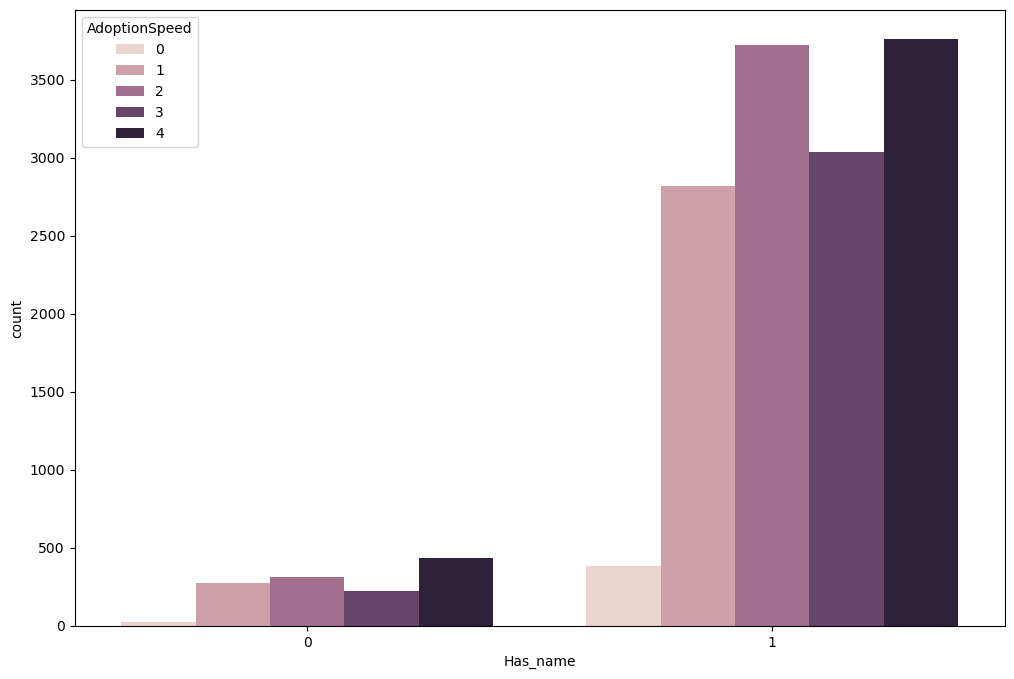

In [11]:
train['Name'] = train['Name'].fillna('Unnamed')
train['Has_name'] = 1
train.loc[train['Name'] == 'Unnamed', 'Has_name'] = 0

sns.countplot(x='Has_name', data=train, hue='AdoptionSpeed');

Text(0.5, 1.0, 'Distribution of pets age in Months')

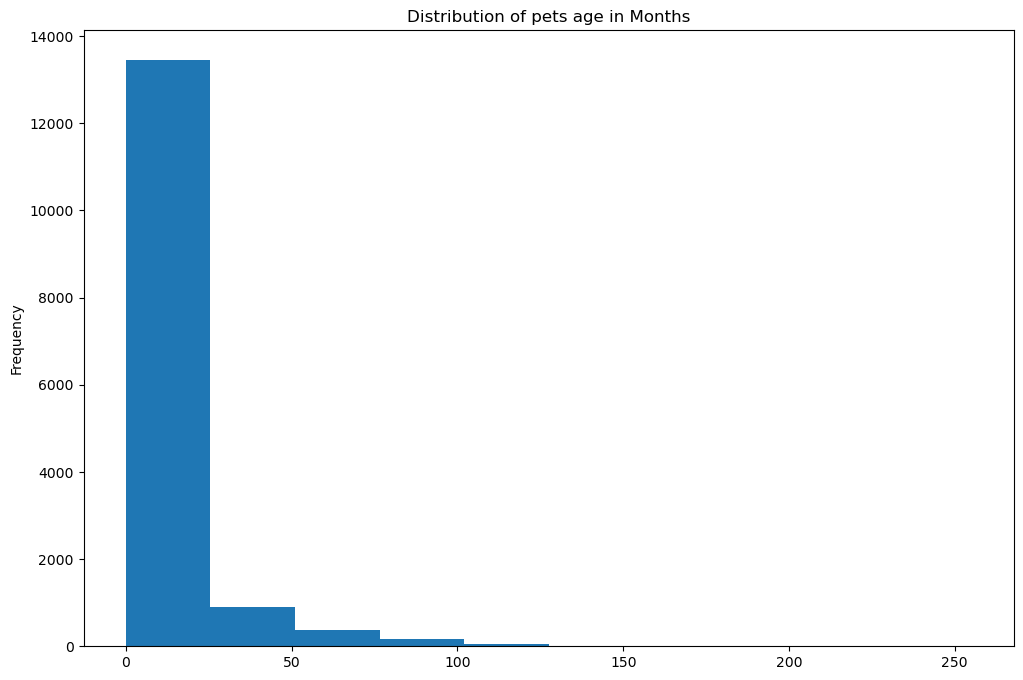

In [12]:
train['Age'].plot(kind='hist')
plt.title('Distribution of pets age in Months')

## Tareas a Realizar

#### Pre-procesamiento:

* Chequear Nulos y Decidir si Imputar o Descartar
* Chequear Variables Categóricas y convertirlas en Numéricas
* Estandarizar o Normalizar

#### Ideas para EDA:

* Analizar la Raza de las Mascotas
* Analizar el Género
* Analizar los 3 Colores Informados para cada Mascota
* Estudiar las variables de Salud: Vacunación, Esterilización, Desparacitación
* Entender el impacto del Fee cobrado
* Estudiar las Regiones Geográficas disponibles
* Analizar el impacto de tener Fotos y/o Videos

Todos estos análisis pueden hacerse en función de la Especie (Gato/Perro) y respecto al Target



## Raza

In [76]:
raza = pd.read_csv("C:/Users/FBorbiconi/OneDrive - Universidad Austral/Documentos/MCD/Laboratorio de implementación 2/Dataset/breed_labels.csv")

In [77]:
breed_dict = dict(zip(raza['BreedID'], raza['BreedName']))
train['Breed1'] = train['Breed1'].map(breed_dict)
train['Breed2'] = train['Breed2'].map(breed_dict).fillna("Animal de Raza")

In [78]:
train_cat = train[train['Type'] == 'Cat']
train_dog = train[train['Type'] == 'Dog']

C:\Users\FBorbiconi\AppData\Local\Temp\ipykernel_30536\2662900932.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cat['Breed1_agrupada'] = train_cat['Breed1'].where(train_cat['Breed1'].isin(freq1), other='Otra')
C:\Users\FBorbiconi\AppData\Local\Temp\ipykernel_30536\2662900932.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dog['Breed1_agrupada'] = train_dog['Breed1'].where(train_dog['Breed1'].isin(freq2), other='Otra')


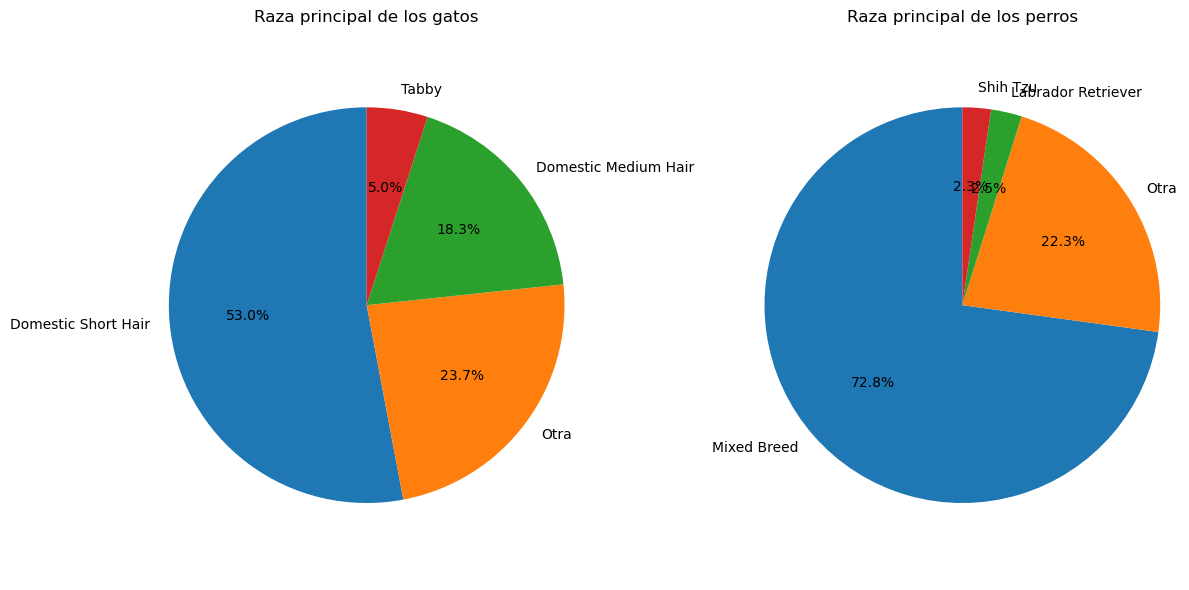

In [79]:
# ----------- GRAFICO 1: Raza principal (Breed1) -----------------------
top_n = 3
freq1 = train_cat['Breed1'].value_counts().nlargest(top_n).index
train_cat['Breed1_agrupada'] = train_cat['Breed1'].where(train_cat['Breed1'].isin(freq1), other='Otra')
counts1 = train_cat['Breed1_agrupada'].value_counts()

# ----------- GRAFICO 2: Raza secundaria (Breed2) ----------------------
freq2 = train_dog['Breed1'].value_counts().nlargest(top_n).index
train_dog['Breed1_agrupada'] = train_dog['Breed1'].where(train_dog['Breed1'].isin(freq2), other='Otra')
counts2 = train_dog['Breed1_agrupada'].value_counts()

# ----------- UNIFICAR EN UNA FIGURA CON SUBPLOTS ---------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 fila, 2 columnas

# Pie chart 1
axes[0].pie(
    counts1,
    labels=counts1.index,
    autopct='%1.1f%%',
    startangle=90
)
axes[0].axis('equal')
axes[0].set_title('Raza principal de los gatos')

# Pie chart 2
axes[1].pie(
    counts2,
    labels=counts2.index,
    autopct='%1.1f%%',
    startangle=90
)
axes[1].axis('equal')
axes[1].set_title('Raza principal de los perros')

plt.tight_layout()
plt.show()

C:\Users\FBorbiconi\AppData\Local\Temp\ipykernel_30536\1809415164.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cat['Breed2_agrupada'] = train_cat['Breed2'].where(train_cat['Breed2'].isin(freq1), other='Otra')
C:\Users\FBorbiconi\AppData\Local\Temp\ipykernel_30536\1809415164.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dog['Breed2_agrupada'] = train_dog['Breed2'].where(train_dog['Breed2'].isin(freq2), other='Otra')


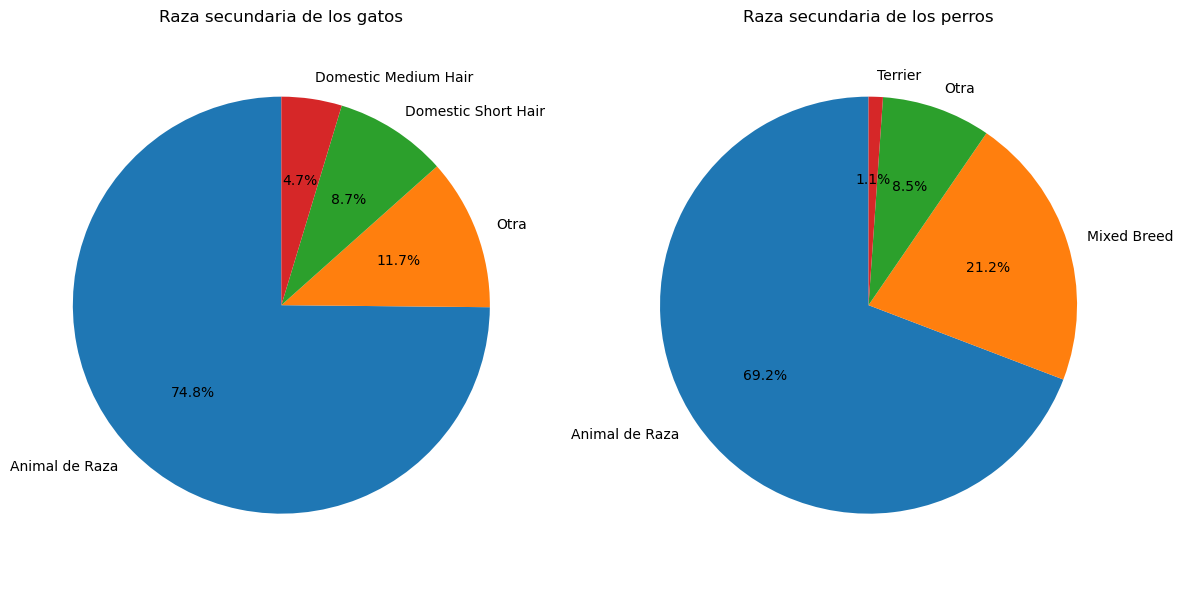

In [80]:
# ----------- GRAFICO 1: Raza secuandaria (Breed2) -----------------------
top_n = 3
freq1 = train_cat['Breed2'].value_counts().nlargest(top_n).index
train_cat['Breed2_agrupada'] = train_cat['Breed2'].where(train_cat['Breed2'].isin(freq1), other='Otra')
counts1 = train_cat['Breed2_agrupada'].value_counts()

# ----------- GRAFICO 2: Raza secundaria (Breed2) ----------------------
freq2 = train_dog['Breed2'].value_counts().nlargest(top_n).index
train_dog['Breed2_agrupada'] = train_dog['Breed2'].where(train_dog['Breed2'].isin(freq2), other='Otra')
counts2 = train_dog['Breed2_agrupada'].value_counts()

# ----------- UNIFICAR EN UNA FIGURA CON SUBPLOTS ---------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 fila, 2 columnas

# Pie chart 1
axes[0].pie(
    counts1,
    labels=counts1.index,
    autopct='%1.1f%%',
    startangle=90
)
axes[0].axis('equal')
axes[0].set_title('Raza secundaria de los gatos')

# Pie chart 2
axes[1].pie(
    counts2,
    labels=counts2.index,
    autopct='%1.1f%%',
    startangle=90
)
axes[1].axis('equal')
axes[1].set_title('Raza secundaria de los perros')

plt.tight_layout()
plt.show()

## Raza vs adopción

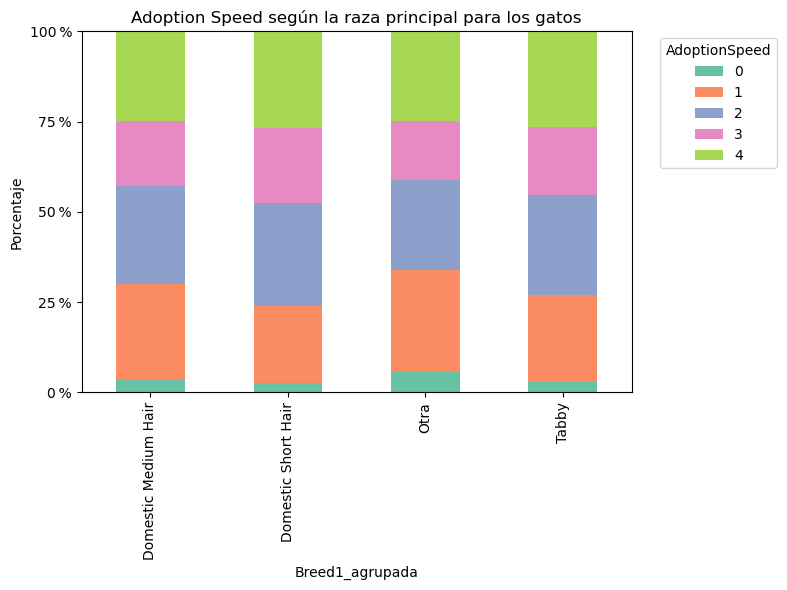

In [81]:
col_raza  = 'Breed1_agrupada'
col_nivel = 'AdoptionSpeed'

# --- 1. Tabla porcentual por raza --------------------------------------
tabla_pct = pd.crosstab(train_cat[col_raza],              # filas = raza agrupada
                        train_cat[col_nivel],             # columnas = niveles
                        normalize='index')         # cada fila suma 1 (100 %)

# --- 2. Gráfico 100 % apilado (barras normales de pandas) --------------
tabla_pct.plot(kind='bar',
               stacked=True,
               figsize=(8, 6),
               color=sns.color_palette('Set2',
                                       n_colors=tabla_pct.shape[1]))

plt.ylabel('Porcentaje')
plt.title('Adoption Speed según la raza principal para los gatos')
plt.ylim(0, 1)
plt.yticks([0, .25, .5, .75, 1], ['0 %', '25 %', '50 %', '75 %', '100 %'])
plt.legend(title=col_nivel, bbox_to_anchor=(1.04, 1), loc='upper left')
plt.tight_layout()
plt.show()

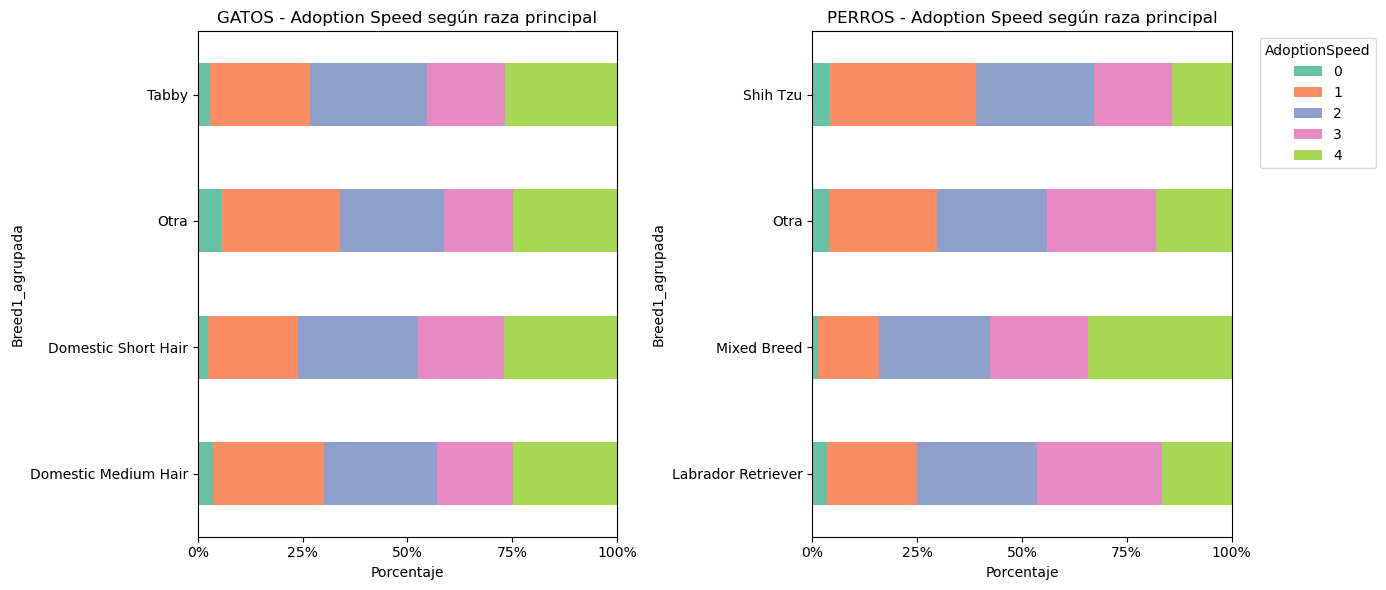

In [82]:
# Configuración
col_raza = 'Breed1_agrupada'
col_nivel = 'AdoptionSpeed'
palette = sns.color_palette('Set2')

# ---- 1. GATOS: tabla porcentual -----------------------------------
tabla_gatos = pd.crosstab(train_cat[col_raza],
                          train_cat[col_nivel],
                          normalize='index')

# ---- 2. PERROS: tabla porcentual -----------------------------------
tabla_perros = pd.crosstab(train_dog[col_raza],
                           train_dog[col_nivel],
                           normalize='index')

# ---- 3. Subplots horizontales -------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# GATOS
tabla_gatos.plot(kind='barh',
                 stacked=True,
                 ax=axes[0],
                 color=palette,
                 legend=False)
axes[0].set_title('GATOS - Adoption Speed según raza principal')
axes[0].set_xlabel('Porcentaje')
axes[0].set_xlim(0, 1)
axes[0].set_xticks([0, .25, .5, .75, 1])
axes[0].set_xticklabels(['0%', '25%', '50%', '75%', '100%'])

# PERROS
tabla_perros.plot(kind='barh',
                  stacked=True,
                  ax=axes[1],
                  color=palette,
                  legend=True)
axes[1].set_title('PERROS - Adoption Speed según raza principal')
axes[1].set_xlabel('Porcentaje')
axes[1].set_xlim(0, 1)
axes[1].set_xticks([0, .25, .5, .75, 1])
axes[1].set_xticklabels(['0%', '25%', '50%', '75%', '100%'])

# Leyenda
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, labels, title='AdoptionSpeed',
               bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


## Género

C:\Users\FBorbiconi\AppData\Local\Temp\ipykernel_30536\2079685227.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cat['Gender'] = train_cat['Gender'].map({
C:\Users\FBorbiconi\AppData\Local\Temp\ipykernel_30536\2079685227.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dog['Gender'] = train_dog['Gender'].map({


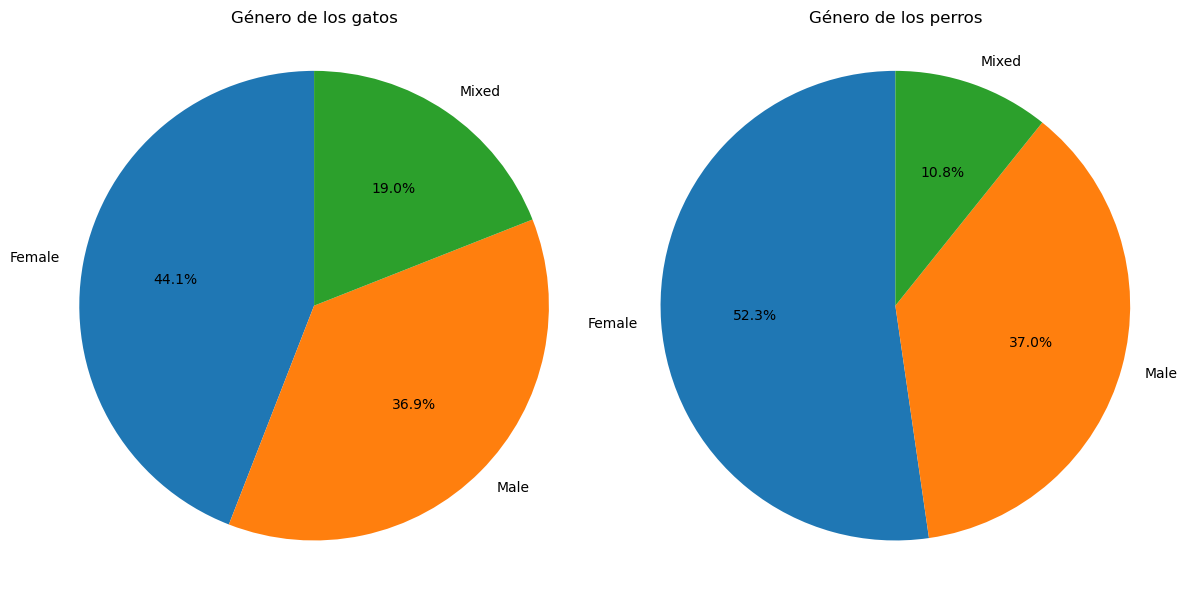

In [83]:
train_cat['Gender'] = train_cat['Gender'].map({
    1: 'Male',
    2: 'Female',
    3: 'Mixed'
})
counts1 = train_cat['Gender'].value_counts()

train_dog['Gender'] = train_dog['Gender'].map({
    1: 'Male',
    2: 'Female',
    3: 'Mixed'
})
counts2 = train_dog['Gender'].value_counts()

# ----------- UNIFICAR EN UNA FIGURA CON SUBPLOTS ---------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 fila, 2 columnas

# Pie chart 1
axes[0].pie(
    counts1,
    labels=counts1.index,
    autopct='%1.1f%%',
    startangle=90
)
axes[0].axis('equal')
axes[0].set_title('Género de los gatos')

# Pie chart 2
axes[1].pie(
    counts2,
    labels=counts2.index,
    autopct='%1.1f%%',
    startangle=90
)
axes[1].axis('equal')
axes[1].set_title('Género de los perros')

plt.tight_layout()
plt.show()

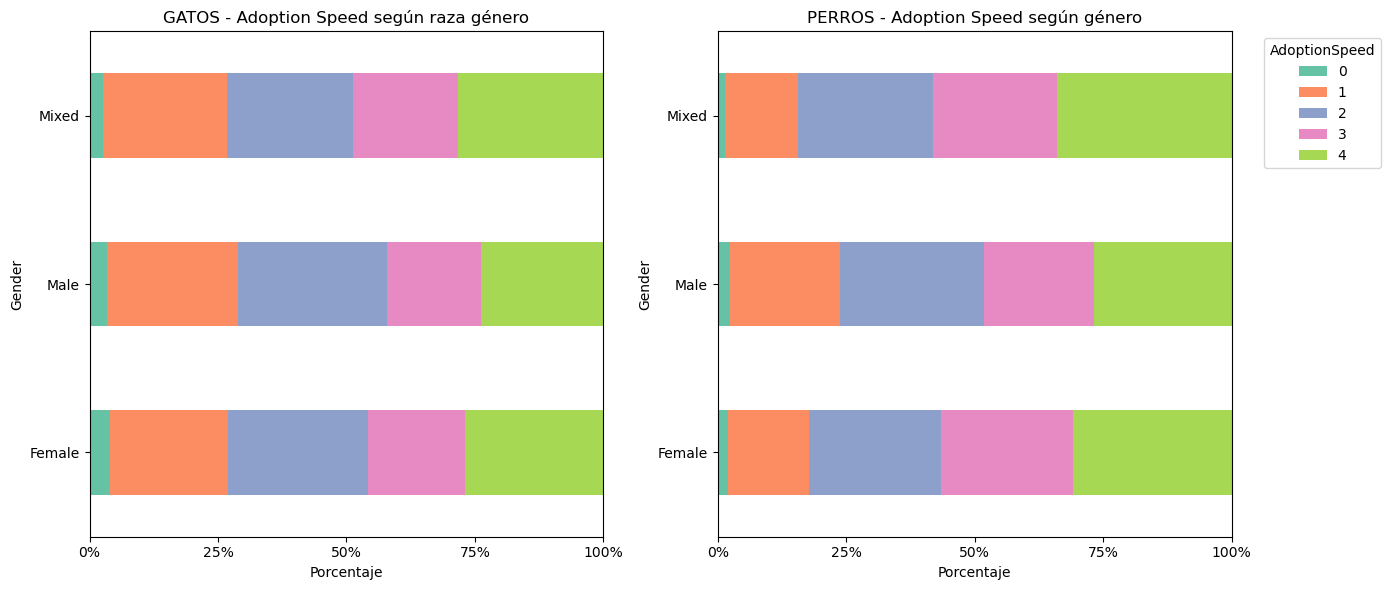

In [84]:
# Configuración
col_genero = 'Gender'
col_nivel = 'AdoptionSpeed'
palette = sns.color_palette('Set2')

# ---- 1. GATOS: tabla porcentual -----------------------------------
tabla_gatos = pd.crosstab(train_cat[col_genero],
                          train_cat[col_nivel],
                          normalize='index')

# ---- 2. PERROS: tabla porcentual -----------------------------------
tabla_perros = pd.crosstab(train_dog[col_genero],
                           train_dog[col_nivel],
                           normalize='index')

# ---- 3. Subplots horizontales -------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# GATOS
tabla_gatos.plot(kind='barh',
                 stacked=True,
                 ax=axes[0],
                 color=palette,
                 legend=False)
axes[0].set_title('GATOS - Adoption Speed según raza género')
axes[0].set_xlabel('Porcentaje')
axes[0].set_xlim(0, 1)
axes[0].set_xticks([0, .25, .5, .75, 1])
axes[0].set_xticklabels(['0%', '25%', '50%', '75%', '100%'])

# PERROS
tabla_perros.plot(kind='barh',
                  stacked=True,
                  ax=axes[1],
                  color=palette,
                  legend=True)
axes[1].set_title('PERROS - Adoption Speed según género')
axes[1].set_xlabel('Porcentaje')
axes[1].set_xlim(0, 1)
axes[1].set_xticks([0, .25, .5, .75, 1])
axes[1].set_xticklabels(['0%', '25%', '50%', '75%', '100%'])

# Leyenda
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, labels, title='AdoptionSpeed',
               bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Fee cobrado

C:\Users\FBorbiconi\AppData\Local\Temp\ipykernel_30536\2497531027.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='AdoptionSpeed')


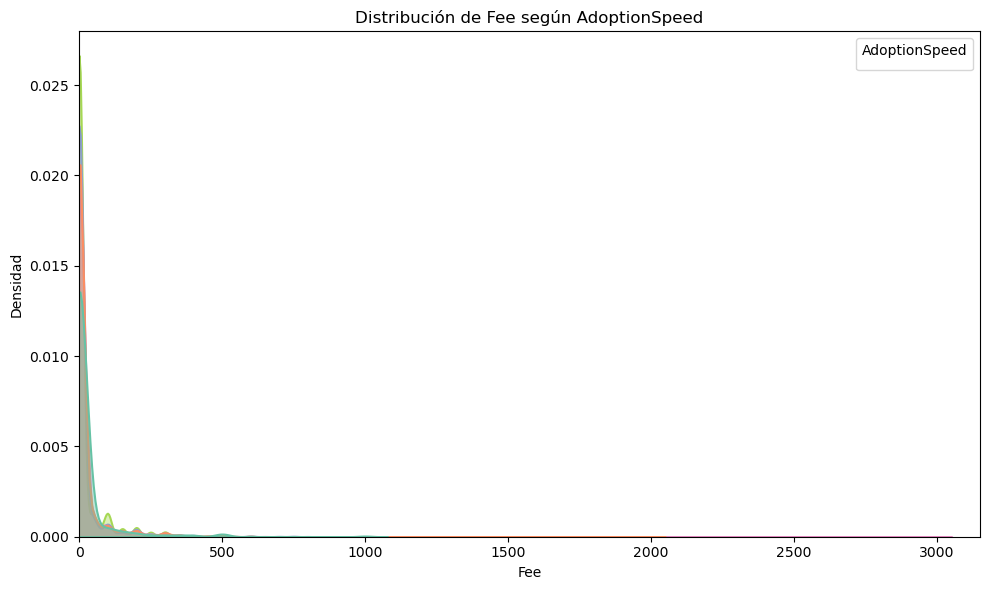

In [88]:
plt.figure(figsize=(10, 6))

sns.kdeplot(
    data=train,
    x='Fee',
    hue='AdoptionSpeed',
    fill=True,         # rellena bajo la curva
    common_norm=False, # normaliza por grupo, no globalmente
    alpha=0.4,         # transparencia
    linewidth=1.5,
    palette='Set2'
)

plt.title('Distribución de Fee según AdoptionSpeed')
plt.xlabel('Fee')
plt.ylabel('Densidad')
plt.xlim(0, train['Fee'].max() * 1.05)  # Opcional, para cortar en el máximo real
plt.legend(title='AdoptionSpeed')
plt.tight_layout()
plt.show()

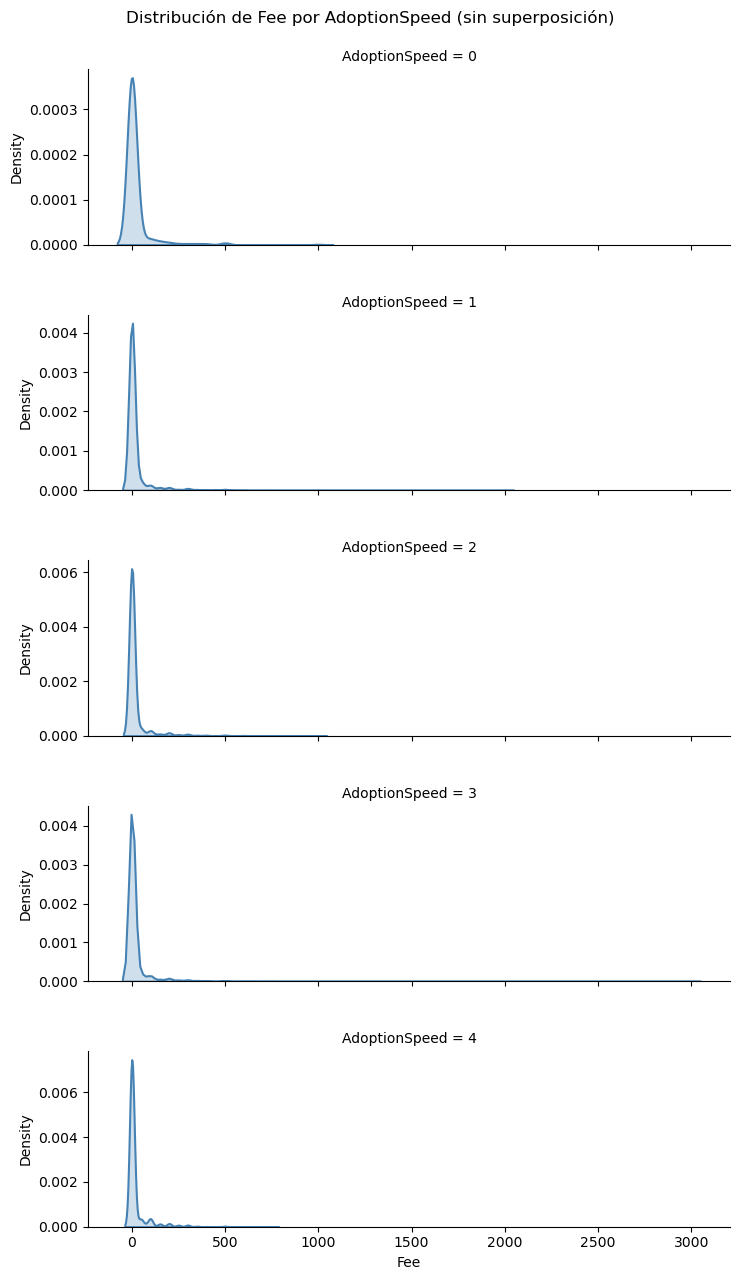

In [ ]:
train.groupby('AdoptionSpeed')